# Technical Document

Nick Holden: 12178855
Noah Fischer: 12232441
Mingwei Ma: 12110380

# Literature Review

High-order Hidden Markov Model for trend prediction in financial time series (Physica A, 2019). Zhang et al use almost exactly the same methodology as the one we adopted. Though they used 3 hidden states and tested their method on CSI300 and SP500 data. They also considered higher order HMMs and tried some dimension reduction techniques which we did not experiment with in our analysis.  

Hidden Markov Models Applied To Intraday Momentum Trading With Side Information (arXiv:2006.08307, 2020). This paper makes two innovations on the common HMM method. First, rather than being pre-specified, its model is estimated using cross validation, penalized likelihood criteria and simulation-based model selection. Also, it considers using side information as part of the feature (observation) vector to improve trading signal performance.

# Trading Environment

We trade 15 of the most liquid commodity contracts traded in the two futures exchanges in Dalian and Zhengzhou, China. The contracts include a wide range of commodities including non-ferrous metals, precious metals, agricultural products and chemical products. Most contracts are traded weekdays $8:30-11:30$am and $9-11$pm or continuously 24 hours a day 5 days a week.  Average annual contract volumes are in the hundreds of millions, and the market is quite sizable and liquid. An important attribute of the Chinese commodities market is its immaturity.  On each ticker within the set of main expiry commodities contracts, there exists a roughly 2-3\% wide spread.  This allows for significant scalping and market making opportunities.  We also note a small influx of "smart money" investors slowly entering this trading environment.  

# Our Model

A Hidden Markov Model (HMM) is a state-space model that can be used to model a wide range of processes. It consists of hidden states that evolve over time as a Markov process, and at each time the hidden state emits an observation according to a noisy distribution. With the observations, one can learn the transition and emission probabilities as well as infer the hidden state of the system based on observations.  We model the process that generates the observed returns as an HMM. We assume at each time $t$, the market is in a hidden state $1,...6$, where 6 is the state with strongest momentum ("Bull") and 1 is the state with least momentum ("Bear"). At bull states we are more likely to see positive returns in a future time period and at bear states the opposite holds. We learn the HMM using historical data and we deduce hidden states with the HMM by feeding it price-volume features extracted from a fixed historical window.  We use a Gaussian HMM model from the $hmmlearn$ Python package. 

Compared to other state-space models such as LSTM, HMM has the advantage of being simple and more interpretable. The model has fewer parameters to estimate and is therefore more robust. Another advantage of HMM over comparable models is that we know the sate of the system at any time, whereas models like LSTM are a complete black box.  Existing momentum trading models suffer from time-lagging caused by the delayed frequency response of digital filters. Time-lagging results in a momentum signal of the wrong sign, when the market changes trend direction. A key feature of this state space formulation is that no such lagging occurs, allowing for accurate shifts in signal sign at market change points. Our HMM strategy essentially captures momentum of the market by labeling it into bull and bear states. Compared to simple mechanical momentum strategies such as using the MACD or fast-and-slow moving averages, HMM has the advantage of learning its parameters from the observations so it can make full use of our historical data. HMM can also take in much more complex features compared to simple momentum strategies that can only take in past prices in a straightforward manner.

Below, we have an example plot of the hidden states exhibited by a commodity over time.

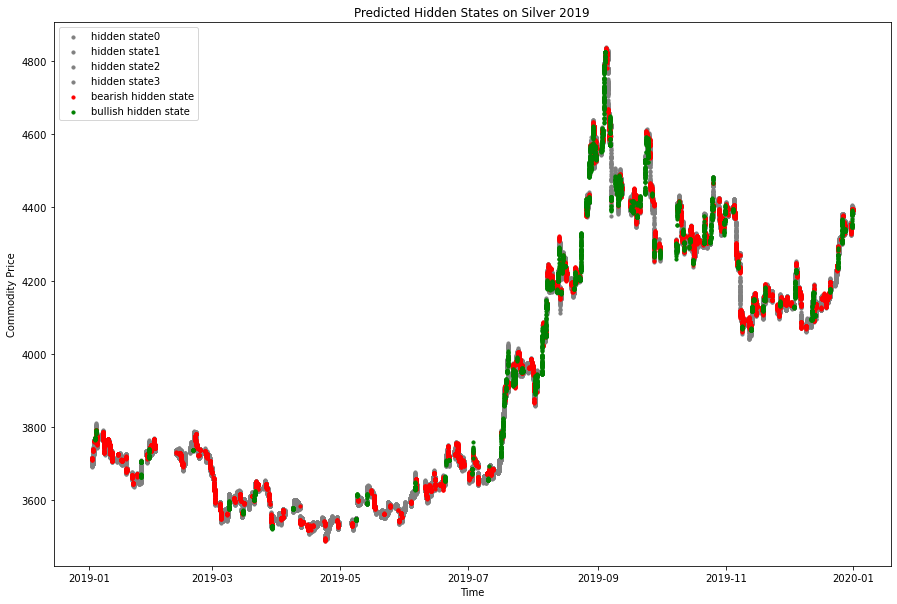

In [34]:
plot_hidden_states(df19,hidden_states19,6,'Predicted Hidden States on Silver 2019',states19[0],states19[1])

# Our Trading Strategy

We select the state for which subsequent 30 minute returns is maximized.  We call this the "bull state" and purchase all commodities across our cross section of 15 main expiry contracts exhibiting its respective bull state at minute $t$ and hold until time $t+30$.  We allocate cash in a $\frac{1}{n}$ manner equally across all bull state exhibiting contracts.  We chose 30 minutes as our holding parameter because many human CTA traders use candle stick plots at 1/5/30min frequency. We believe 30 minutes is a good time frame to capture market psychology. Also, this time frame is long enough to be unaffected by liquidity constraints and microstructure effects.  Note that we do not include a stop loss.  Our decision for this was to demonstrate the effectiveness of buying on the bull state, which a stop loss does not help us accomplish.  Additionally, our time horizon is short enough such that dramatic moves are highly unlikely.  Below is the function that runs our strategy.

In [207]:
def run_commodity_strategy_daily(commodity, nstates):
    
    test['close'] = df18.resample('D', on='time').last()
    test['close'] = test['close'].pct_change()
    
    df2018 = pd.read_csv('./data/2018/' + commodity + '.csv', index_col=0, encoding='gbk')
    df2019 = pd.read_csv('./data/2019/' + commodity + '.csv', index_col=0, encoding='gbk')
    df2020 = pd.read_csv('./data/2020/' + commodity + '.csv', index_col=0, encoding='gbk')
    
    df18 = prepare_data(clean_df(df2018))
    df18['close'] = df18.resample('D', on='time').last()
    df18['close'] = df18['close'].pct_change()
    
    df19 = prepare_data(clean_df(df2019))
    df19['close'] = df19.resample('D', on='time').last()
    df19['close'] = df19['close'].pct_change()
    
    df20 = prepare_data(clean_df(df2020))
    df20['close'] = df20.resample('D', on='time').last()
    df20['close'] = df20['close'].pct_change()
    
    
    
    hmm18 = train_model(df18,nstates)
    hmm19 = train_model(df19,nstates)
    
    hidden_states18 = fit_model(hmm18,df18)
    hidden_states19 = fit_model(hmm19,df19)
    
    states18 = pick_bull_bear(df18,hidden_states18,nstates)
    states19 = pick_bull_bear(df19,hidden_states19,nstates)
    print("bull_bear completed 2018 bull",states18[0],'2018 bear',states18[1])
    print("bull_bear completed 2019 bull",states19[0],'2019 bear',states19[1])

    returns19 = commodity_helper(hmm18,states18[0],states18[1],df19,0.01)
    ret19 = pd.Series(returns19)
    print(commodity + '2019 mean returns trained on 2018 data:',ret19.mean(),'cumulative:',ret19.sum())
    returns20 = commodity_helper(hmm19,states19[0],states19[1],df20,0.01)
    ret20 = pd.Series(returns20)

    print(commodity + '2020 mean returns trained on 2019 data:',ret20.mean(),'cumulative:',ret20.sum())

    return (returns19,returns20)

# Performance Analysis

First, Consider the performance of each commodity denoted by the cumulative $PnL$ over the time period.  We plot these below for 2019.  

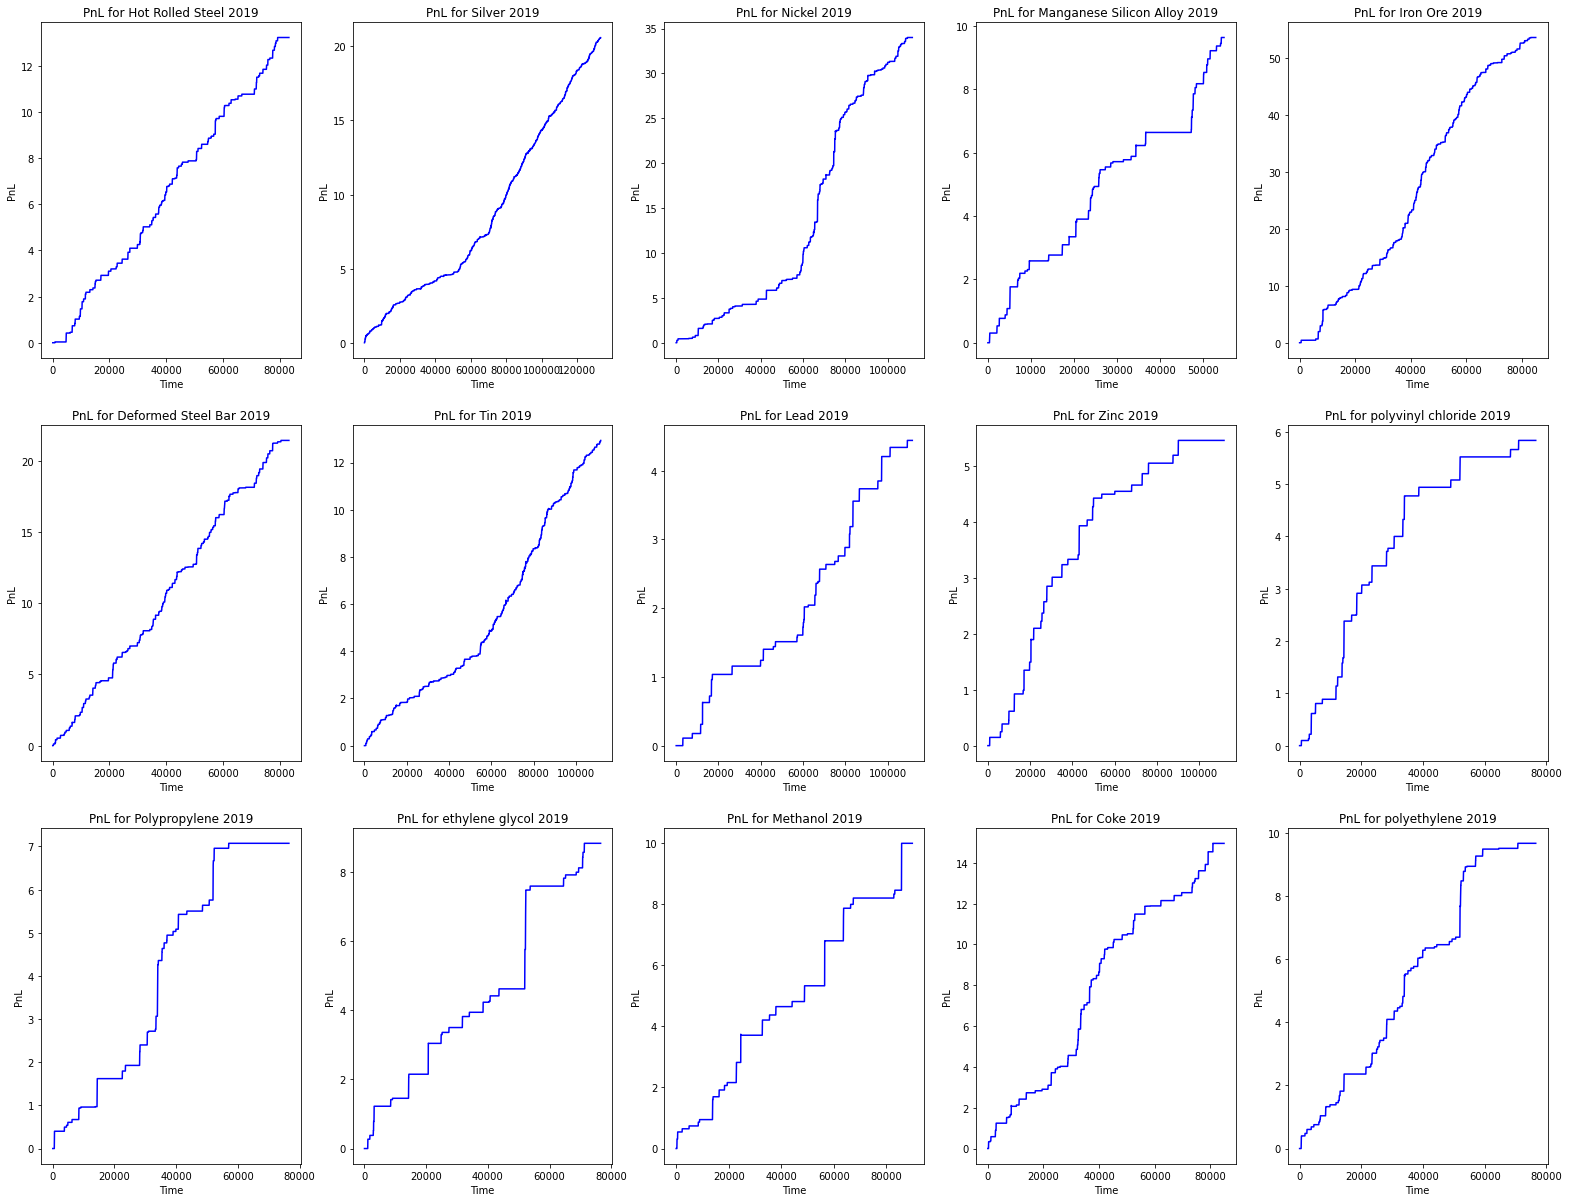

In [222]:
k=1
fig, axs = plt.subplots(3, 5, figsize=(27,21))

j=0
colors = ['b', 'b', 'b', 'b', 'b']

for row in range(0,3):
    for col in range(0,5):
        axs[row][col].plot((metals2019[metals2019.columns[j]]*k).cumsum(), color=colors[col])
        axs[row][col].title.set_text('PnL for ' + str(metals2019.columns[j]))
        axs[row][col].set_xlabel('Time')
        axs[row][col].set_ylabel('PnL')
        j+=1

Now, we plot $PnL$ for 2020.  

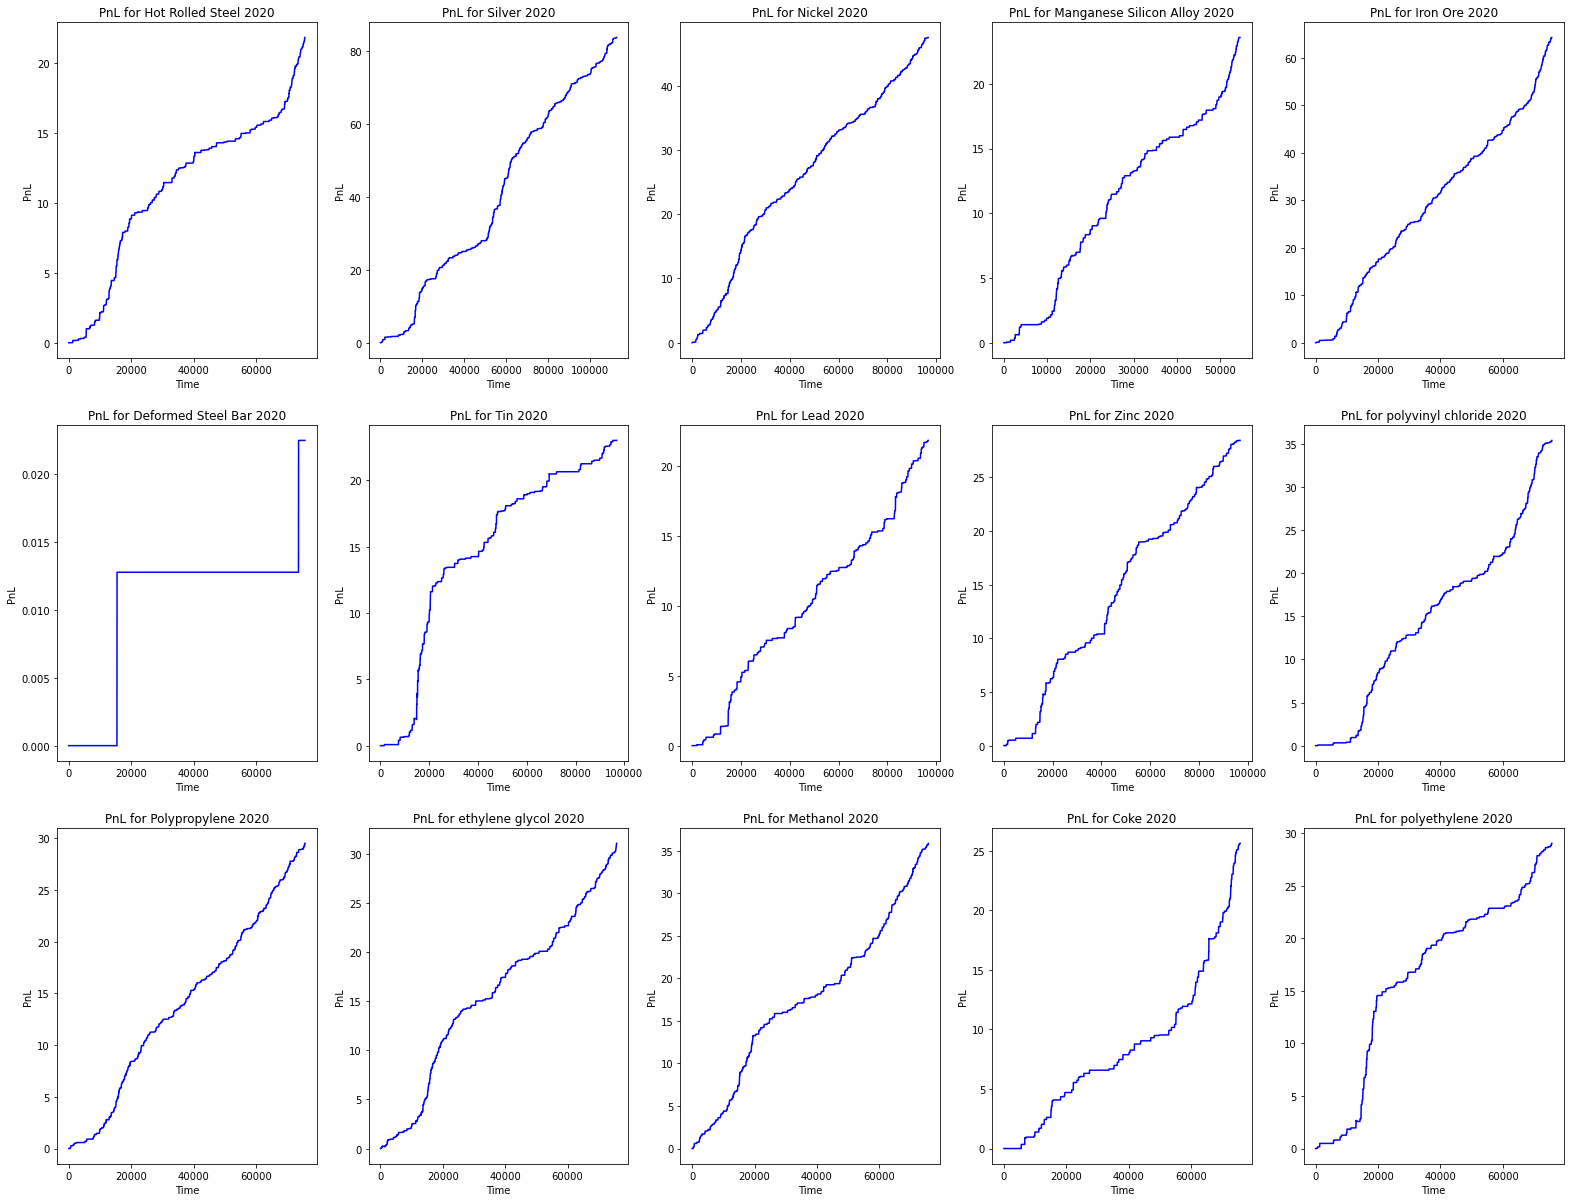

In [223]:
k=1
fig, axs = plt.subplots(3, 5, figsize=(27,21))

j=0
colors = ['b', 'b', 'b', 'b', 'b']

for row in range(0,3):
    for col in range(0,5):
        axs[row][col].plot((metals2020[metals2020.columns[j]]*k).cumsum(), color=colors[col])
        axs[row][col].title.set_text('PnL for ' + str(metals2020.columns[j]))
        axs[row][col].set_xlabel('Time')
        axs[row][col].set_ylabel('PnL')
        j+=1

Next, consider the distributions of minutely returns by commodity for 2019.  We plot them.  

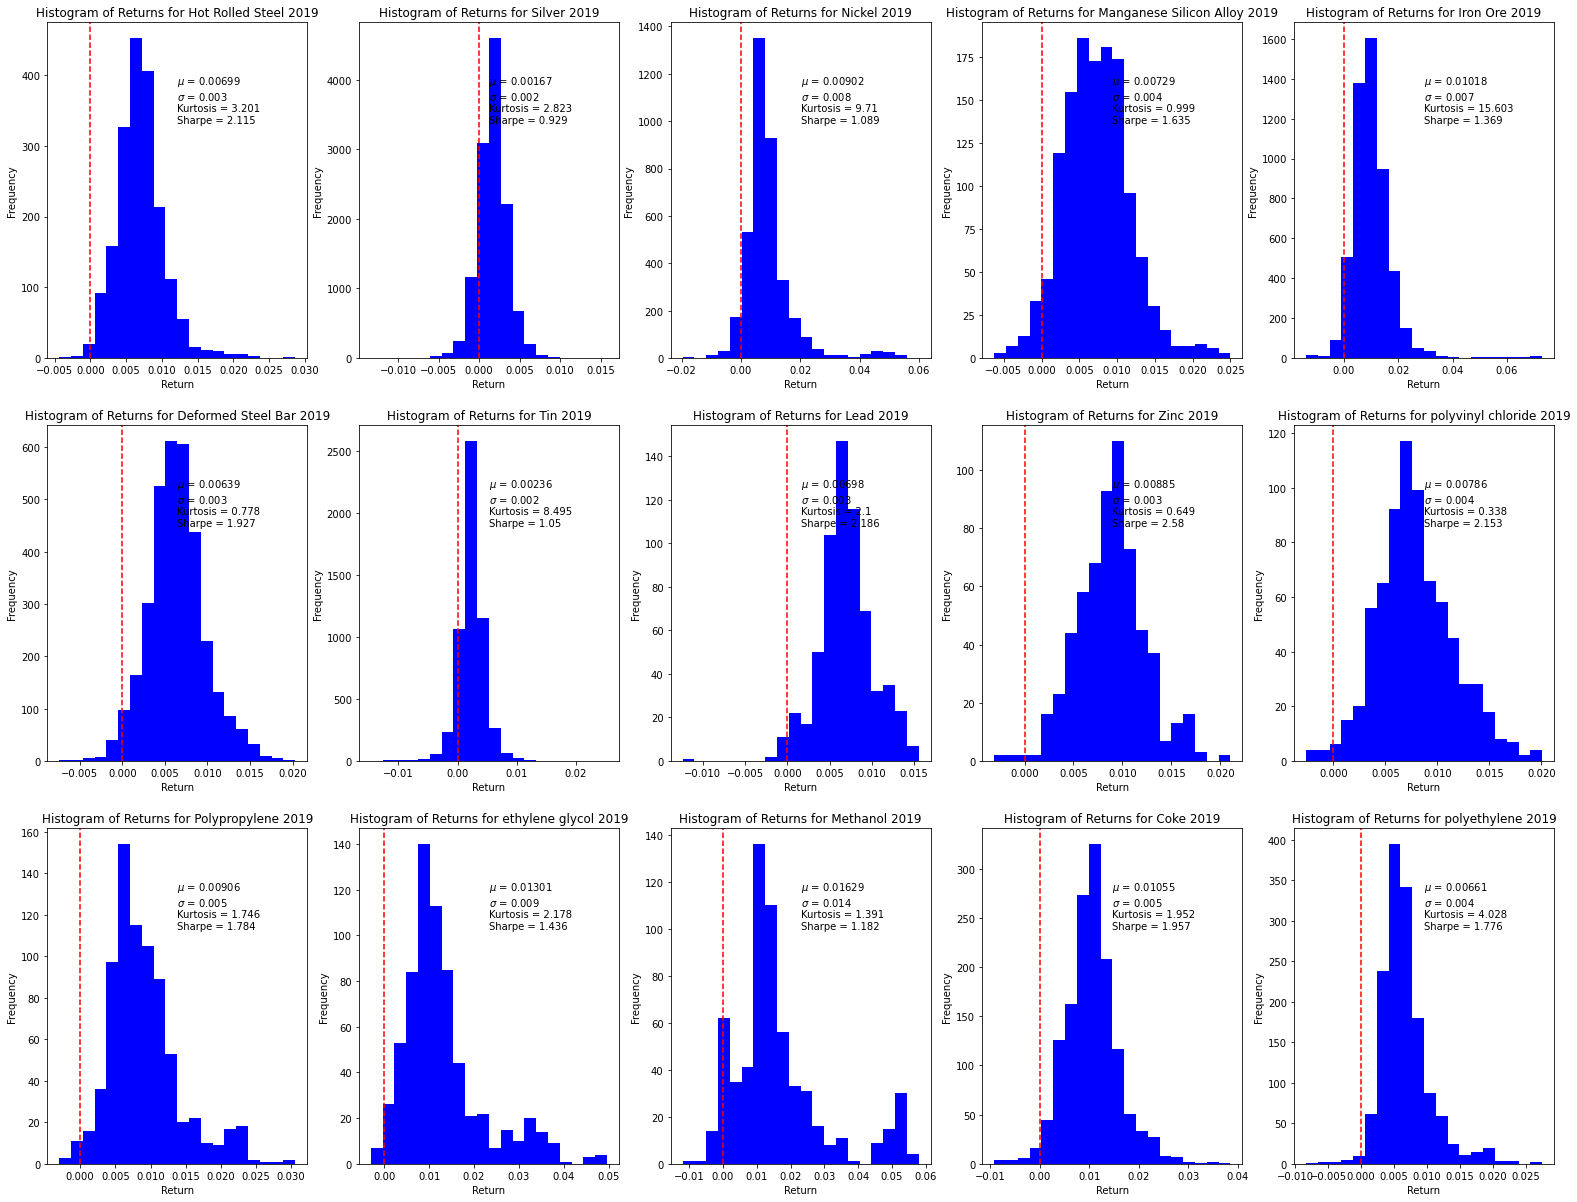

In [219]:
fig, axs = plt.subplots(3, 5, figsize=(27,21))

j=0
colors = ['b', 'b', 'b', 'b', 'b']

for row in range(0,3):
    for col in range(0,5):
        
        series = metals2019.loc[ (metals2019[metals2019.columns[j]] !=0) & ~(metals2019[metals2019.columns[j]].isna())][metals2019.columns[j]]
        
        axs[row][col].hist(x=series, bins=20, color=colors[col])
        axs[row][col].axvline(x=0, color='r', linestyle='--')
        axs[row][col].title.set_text('Histogram of Returns for ' + str(metals2019.columns[j]))
        axs[row][col].annotate('$\mu$ = ' + str(round(np.mean(series),5)) + '\n$\sigma$ = ' +
                str(round(np.std(series),3)) +\
                           '\nKurtosis = ' + str(round(series.kurtosis(),3)) +\
                            '\nSharpe = ' + str(round(np.mean(series) / np.std(series), 3)), xy=(.5, .7), xycoords='axes fraction')
        axs[row][col].set_xlabel('Return')
        axs[row][col].set_ylabel('Frequency')
        j+=1

And now we plot them for 2020.

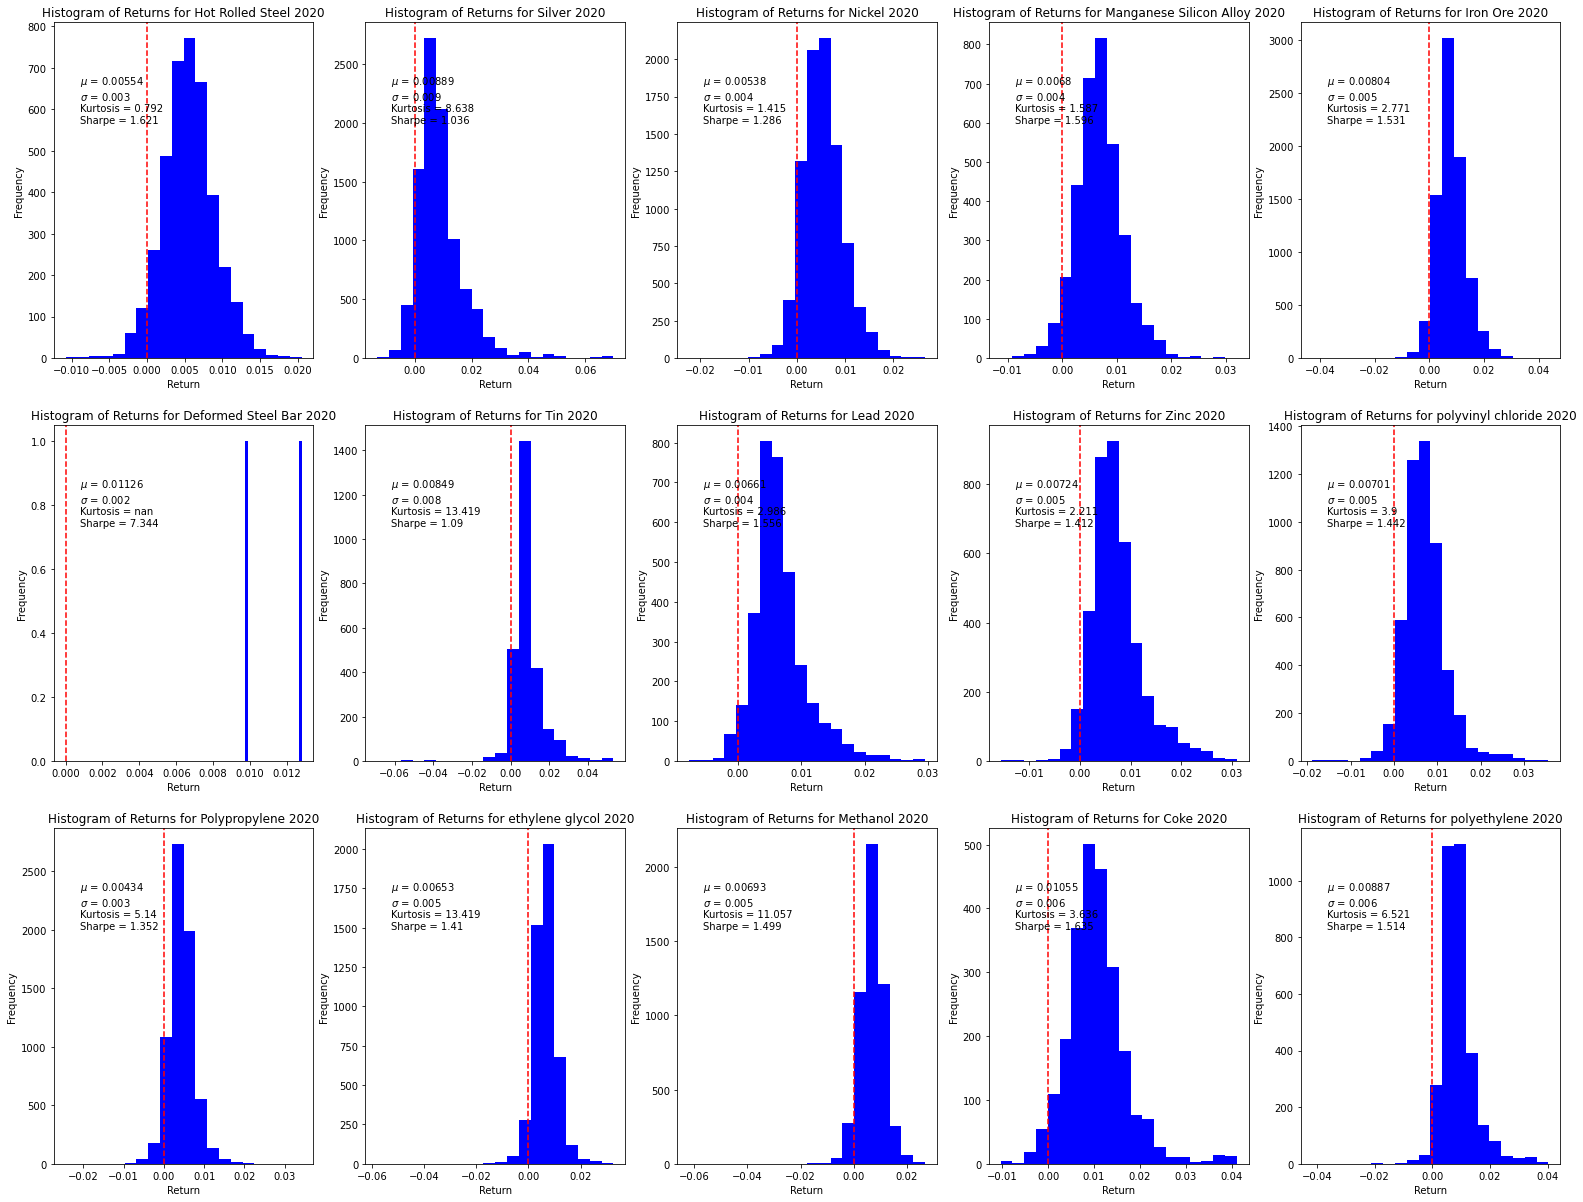

In [220]:
fig, axs = plt.subplots(3, 5, figsize=(27,21))

j=0
colors = ['b', 'b', 'b', 'b', 'b']

for row in range(0,3):
    for col in range(0,5):
        
        series = metals2020.loc[ (metals2020[metals2020.columns[j]] !=0) & ~(metals2020[metals2020.columns[j]].isna())][metals2020.columns[j]]
        
        axs[row][col].hist(x=series, bins=20, color=colors[col])
        axs[row][col].axvline(x=0, color='r', linestyle='--')
        axs[row][col].title.set_text('Histogram of Returns for ' + str(metals2020.columns[j]))
        axs[row][col].annotate('$\mu$ = ' + str(round(np.mean(series),5)) + '\n$\sigma$ = ' +
                str(round(np.std(series),3)) +\
                           '\nKurtosis = ' + str(round(series.kurtosis(),3)) +\
                            '\nSharpe = ' + str(round(np.mean(series) / np.std(series), 3)), xy=(.1, .7), xycoords='axes fraction')
        axs[row][col].set_xlabel('Return')
        axs[row][col].set_ylabel('Frequency')
        j+=1

First, note the difference between these commodities in terms of investibility.  Some commodities exhibit much higher Sharpe ratios, higher kurtoses, and higher mean returns than others.   Contrary to our expectations, the trading environment appears to be improving, with Sharpe ratios and returns more attractive in 2020 than in 2019.  This is a counterintuitive result considering the influx of traders to this immature market.  Continuing, let us consider the cumulative strategy returns and distribution.  First, we plot cumulative $PnL$ of the strategy, then we plot logged $PnL$ of the strategy.  

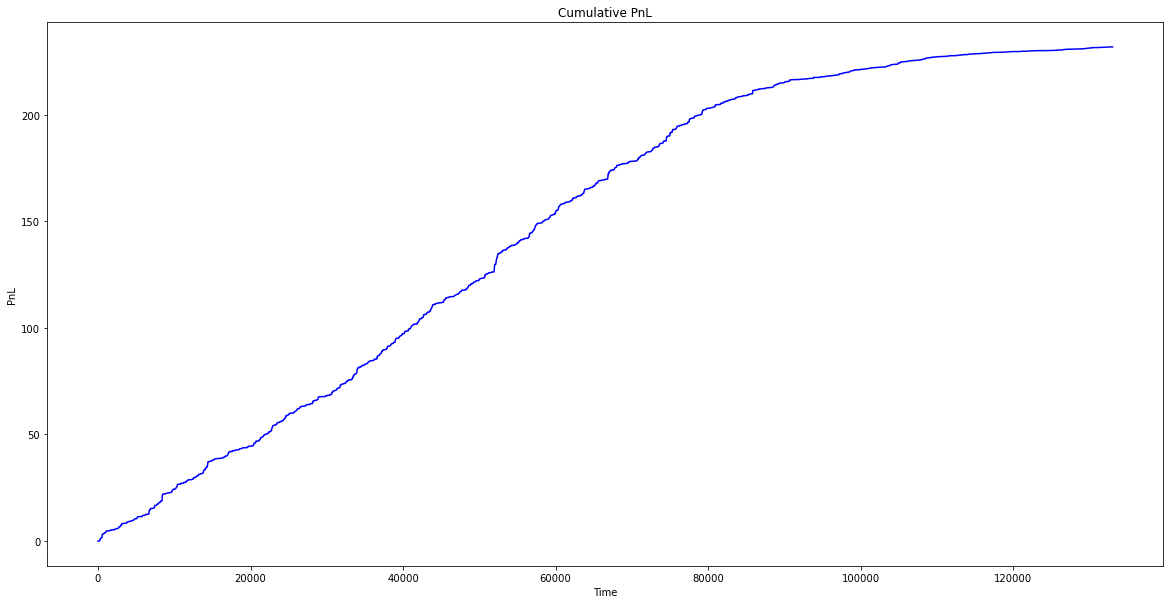

In [217]:
k=1
plt.figure(figsize=(20,10))
plt.plot((metals2019['netret']*k).cumsum(), color=colors[col])
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL')

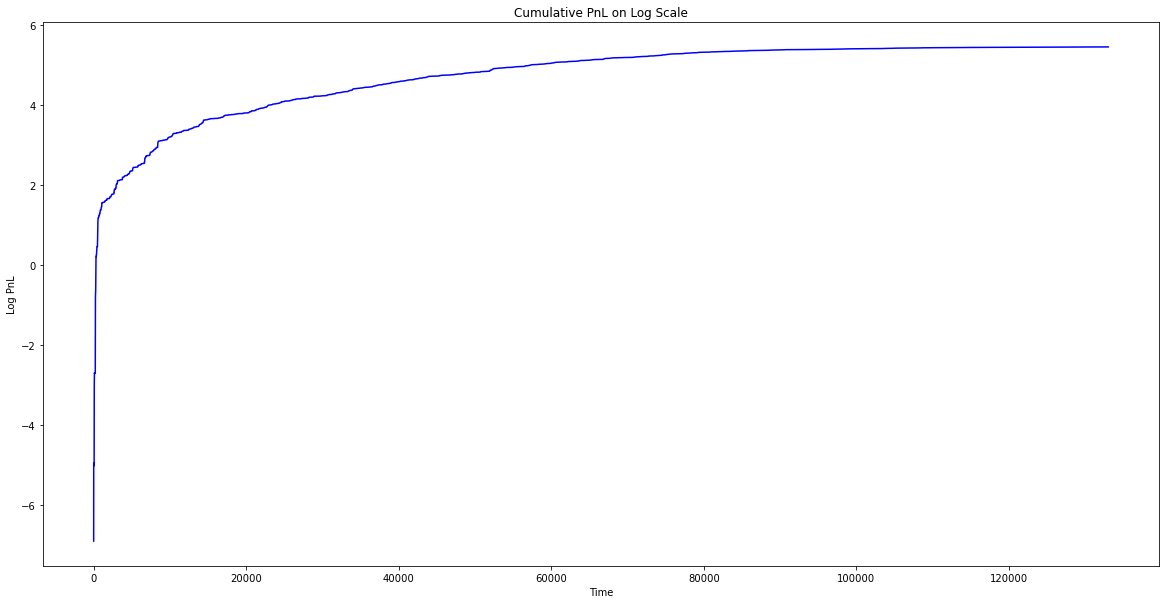

In [216]:
k=1
plt.figure(figsize=(20,10))
plt.plot(np.log( (metals2019['netret']*k).cumsum() ), color=colors[col])
plt.title('Cumulative PnL on Log Scale')
plt.xlabel('Time')
plt.ylabel('Log PnL')

Before we interpret these $PnL$ plots, let us consider the following distribution of returns for the cumulative strategy. 

Text(0, 0.5, 'Frequency')

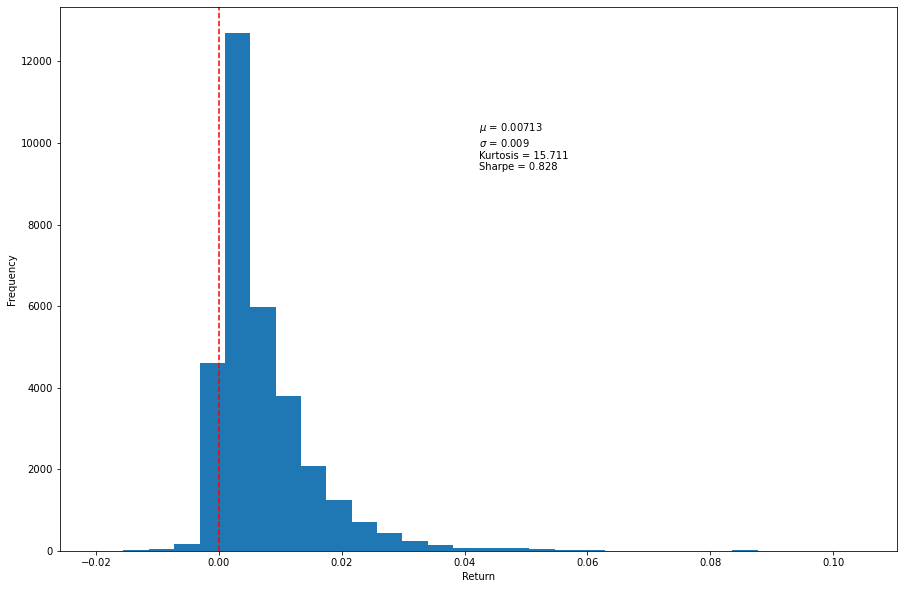

In [21]:
plt.figure(figsize=(15,10))

series = metals2019['netret'].loc[ (metals2019['netret'] != 0) & ~(metals2019['netret'].isna())]

plt.hist(series, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.annotate('$\mu$ = ' + str(round(np.mean(series),5)) + '\n$\sigma$ = ' +
                str(round(np.std(series),3)) +\
                           '\nKurtosis = ' + str(round(series.kurtosis(),3)) +\
                            '\nSharpe = ' + str(round(np.mean(series) / np.std(series), 3)), 
             xy=(.5, .7), xycoords='axes fraction')
plt.xlabel('Return')
plt.ylabel('Frequency')

We see excellent $PnL$ results.  Further, we see a reasonably high Sharpe ratio for the cumulative strategy and excellent Sharpe results for individual contracts.  Our mean cumulative return is positive and the return distribution is right skewed and highly kurtotic.  Note that we include  the exchange listed trading costs of 0.0345% in our backtest.  This strategy seems to be very profitable.

To properly interpret the $PnL$ plots we define recurring investment amount $K$ as the nominal amount invested into each security equaly.  We track cumulative PnL as a function of our constant, small, investment size. This investment size would need to be less than or equal to $\frac{K}{30 \cdot n}$ where $n$ is the number of commodities we are trading and $K$ is our total capital. In our back test we ran this strategy for 15 commodities, so our high frequency trading size would be $\frac{K}{450}$.

# Risks 

Across these commodities, we see a large bid-ask spread of roughly 2-3%.  Our backtest results have a mean return of roughly 0.7% and thus incorporating the spread into backtesting would hurt performance heavily, most likely moving our mean past zero.  Then, we would see somewhat of an inverse carry trade, with a slightly negative mean return, right skew, and high kurtosis.  

While bid-ask spreads are large, we note that there is significant trading volume, with annual Chinese commodity trading totaling 48 trillion dollars.  Thus, we see minimal liquidity risks.  

An additional risk comes from the nature of the HMM itself.  Because HMM states are inherently hidden, there can be no economic rationale or logical basis for their existence.  Thus, should a sizable shock affect the commodities market, the strategy's reaction is not predictable, as the states are not known and cannot be manually corrected even if the effect is known to the traders.  This represents risk during regime changes, geopolitical events, and other statistically rare market shocks.  Further, risks for these events are hard to control since the underlying states cannot be altered.

It is also worth considering currency risk.  By trading on Chinese commodities, we expose ourselves to currency risk to convert earnings back to US dollars.  Additional risk is imposed when converting our initial investment to Yuan.  Should the strategy hold sufficient outside investor capital, the lack of liquidity for a client can be a large downside to investing.  

# Conclusions

Overall, we see that this model is quite promising.  However, without tick-level data to examine the effects of the wide bid-ask spread, we cannot make a definitive statement on the tradeability of the HMM strategy.  We can say that using an HMM as a predictor of equity returns appears to be a promising avenue for traders, particularly in the developing Chinese commodities market.  It is also worth noting that our HMM uses a single layer for prediction.  Current literature suggests that deepening the model with more layers or vecorizing the inputs to the HMM can yield better prediction results and subsequently more profitable and consistent trading.  Additionally, we have chosen parameter that are able to be scaled sufficiently and allows for implementation, such as our $K$ capital parameter and 30 minute window.  